# 01 · Introducción a la IA en Audiología — Teoría y práctica de estadística

# 🧠 Módulo 0 — Fundamentos de estadística (resumen de teoría)

*Descriptiva vs. inferencial, niveles de medida, medidas de resumen, forma de la distribución, z-scores, TCL, IC y p-valores, y pitfalls comunes.*

## 1) ¿Qué es la estadística?
- **Descriptiva**: resume lo observado (tablas, medias, gráficos). **No** generaliza.
- **Inferencial**: usa una **muestra** para inferir sobre una **población** (IC, tests, predicción).
- Audiología: describir umbrales vs. estimar el efecto de un ajuste en pacientes nuevos.

## 2) Variables y niveles de medida
- **Nominal** (categorías sin orden), **Ordinal** (orden sin intervalos fijos),
  **Intervalo** (intervalos iguales, cero no absoluto), **Razón** (intervalos iguales, cero absoluto).
> Elegir mal el nivel ⇒ estadísticas/figuras inadecuadas.

## 3) Medidas de tendencia central (centro)
- **Media**: $$\bar{x}=\frac{1}{n}\sum_{i=1}^n x_i$$ (sensible a outliers)
- **Mediana**: punto central (robusta)
- **Moda**: valor más frecuente

## 4) Medidas de dispersión (variabilidad)
- **Rango**: máx − mín
- **Varianza (muestral)**: $$s^2=\frac{1}{n-1}\sum_{i=1}^n (x_i-\bar{x})^2$$
- **Desviación estándar**: $$s=\sqrt{s^2}$$
- **IQR**: Q3 − Q1 (robusta)

## 5) Forma de la distribución
- **Asimetría** y **curtosis** ayudan a diagnosticar colas y outliers.

## 6) Estandarización (z-scores)
- $$z_i=\frac{x_i-\bar{x}}{s}$$ útil para comparar y detectar valores atípicos (p. ej., |z|>3).

## 7) Muestreo, sesgos y tamaño muestral
- Muestras por conveniencia inducen sesgos; n pequeño ⇒ IC anchos.

## 8) Teorema Central del Límite (TCL)
- La media muestral tiende a normal para \(n\) grande ⇒ base de IC y tests sobre medias.

## 9) Intervalos de confianza y p-valores
- **IC 95%**: rango plausible del parámetro.
- **p-valor**: prob. de datos tan/extremos si H0 fuera cierta (no es prob(H0)).
- Reporta **tamaño del efecto** + **IC** > solo p-valor.

## 10) Correlación ≠ causalidad (confusores)
- En audiología: la edad puede confundir relación entre sesiones y resultado.

## 11) Pitfalls frecuentes
- Promediar escalas **ordinales** como si fueran de **intervalo**.
- Ignorar dependencias (medidas por oído/paciente).
- Múltiples comparaciones sin corrección (inflación de falsos positivos).

In [21]:
import pandas as pd
import numpy as np

# Cargar audiogramas (un oído por paciente). Ajusta la ruta si es necesario.
df = pd.read_csv('../data/raw/audiograms.csv')

FREQS = [250, 500, 1000, 2000, 4000, 8000]
F_COLS = [f"f{f}" for f in FREQS]

# Medidas por paciente
df['media_hl'] = df[F_COLS].mean(axis=1)
df['mediana_hl'] = df[F_COLS].median(axis=1)
df['sd_hl'] = df[F_COLS].std(axis=1, ddof=1)
df['iqr_hl'] = df[F_COLS].quantile(0.75, axis=1) - df[F_COLS].quantile(0.25, axis=1)

display(df[['id', 'edad', 'sexo', 'media_hl', 'mediana_hl', 'sd_hl', 'iqr_hl']].head())

# Medidas por frecuencia (todos los pacientes)
desc_by_freq = df[F_COLS].agg(['mean','median','std','min','max']).T
desc_by_freq.index = [c[1:] for c in desc_by_freq.index]  # quitar 'f'
display(desc_by_freq)

# Copia para plots
df_sim = df.copy()

,id,edad,sexo,media_hl,mediana_hl,sd_hl,iqr_hl
0,1,43,F,16.866667,16.85,3.186011,3.625
1,2,27,M,4.316667,3.65,2.996275,2.725
2,3,76,M,65.533333,54.35,24.770197,27.350
3,4,51,F,26.266667,20.65,13.294159,13.625
4,5,50,M,11.866667,13.05,4.848367,6.125


,mean,median,std,min,max
250,30.206250,22.80,26.770630,1.4,110.1
500,32.169375,24.95,26.037907,0.1,112.7
1000,34.908125,28.75,25.888476,2.2,114.1
2000,38.075625,33.95,25.607685,5.6,116.6
4000,42.315625,37.65,27.310047,1.8,118.7
8000,47.581875,43.60,31.248201,0.7,120.0


In [9]:
import numpy as np
FREQS = [250, 500, 1000, 2000, 4000, 8000]
XTICKS = [str(int(f)) for f in FREQS]

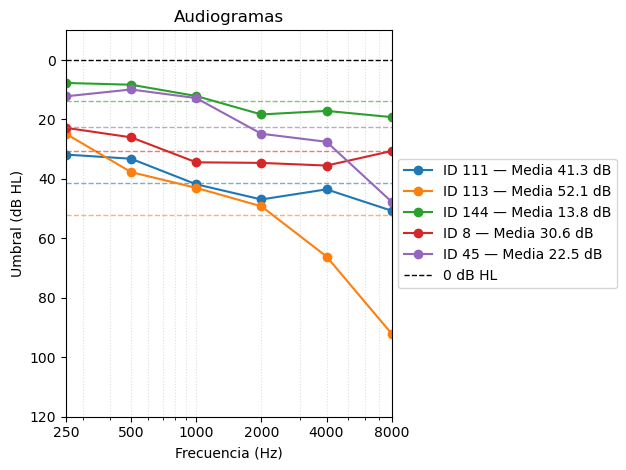

In [19]:
import matplotlib.pyplot as plt
import numpy as np

ex_ids = df_sim["id"].sample(5, random_state=0).tolist()
freqs = np.array(FREQS, dtype=float)

fig, ax = plt.subplots()

for pid in ex_ids:
    r = df_sim.loc[df_sim["id"] == pid].iloc[0]
    y = np.array([r[f"f{int(f)}"] for f in freqs], dtype=float)
    mean_hl = float(y.mean())

    (line,) = ax.plot(freqs, y, marker="o", label=f"ID {pid} — Media {mean_hl:.1f} dB")
    ax.axhline(mean_hl, linestyle="--", linewidth=1, alpha=0.6, color=line.get_color())

ax.set_xscale("log")
ax.set_xticks(freqs); ax.set_xticklabels(XTICKS)
ax.invert_yaxis()
ax.set_ylim(120, -10)              # fixed HL range
ax.set_xlim(freqs.min(), freqs.max())
ax.axhline(0, color="k", linestyle="--", linewidth=1, label="0 dB HL")

ax.set_xlabel("Frecuencia (Hz)")
ax.set_ylabel("Umbral (dB HL)")
ax.set_title("Audiogramas")

# legend outside (right)
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
fig.tight_layout()

ax.grid(True, which="both", axis="x", linestyle=":", alpha=0.4)
plt.show()